In [52]:
import pandas as pd

df = pd.read_csv('../Dataset/FeatureEngineering_T2M_data.csv')
df.tail()

,date,tsoil1,tsoil2,tsoil3,tsoil4,t2m,t2m_max,t2m_min,t10m,t10m_max,...,v2m_roll7_mean,v2m_roll7_std,v10m_roll3_mean,v10m_roll3_std,v10m_roll7_mean,v10m_roll7_std,v50m_roll3_mean,v50m_roll3_std,v50m_roll7_mean,v50m_roll7_std
16373,2025-11-06,25.73,25.71,26.11,26.56,26.15,29.52,23.51,26.16,29.34,...,-0.430000,1.514640,-2.353333,0.184752,-0.525714,1.994750,-3.210000,0.280000,-0.681429,2.766071
16374,2025-11-07,25.82,25.99,26.12,26.53,26.40,27.92,24.67,26.55,27.90,...,-0.832857,1.431220,-2.436667,0.040415,-1.067143,1.896898,-3.333333,0.075056,-1.421429,2.644343
16375,2025-11-08,26.35,26.09,26.14,26.51,27.16,29.76,25.52,27.35,29.63,...,-0.900000,1.316536,-1.213333,2.098960,-1.160000,1.739071,-1.660000,2.902154,-1.567143,2.395097
16376,2025-11-09,27.01,26.53,26.25,26.50,27.78,30.85,25.51,28.00,30.76,...,-0.872857,1.364291,0.176667,2.236813,-1.118571,1.812672,0.280000,3.086794,-1.507143,2.501937
16377,2025-11-10,27.22,26.89,26.45,26.50,27.96,30.47,26.15,28.21,30.25,...,-0.717143,1.407548,1.026667,0.791096,-0.910000,1.871363,1.473333,1.061712,-1.210000,2.588906


### X, y and Train / Test for Time Series

In [53]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

In [54]:
H = 7
t2m_targets = [f"t2m_d{h}_forecast" for h in range(1, H+1)]

In [55]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

feature_cols = [c for c in num_cols if c not in t2m_targets]

print("Number of features:", len(feature_cols))
print("Targets:", t2m_targets)

Number of features: 334
Targets: ['t2m_d1_forecast', 't2m_d2_forecast', 't2m_d3_forecast', 't2m_d4_forecast', 't2m_d5_forecast', 't2m_d6_forecast', 't2m_d7_forecast']


In [56]:
X = df[feature_cols]         # shape = (n_samples, n_features)
Y = df[t2m_targets]           # shape = (n_samples, 7)

In [57]:
test_ratio = 0.2
n_samples = len(df)
split_idx = int(n_samples * (1 - test_ratio))

# split
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
Y_train, Y_test = Y.iloc[:split_idx], Y.iloc[split_idx:]

print("Train size:", X_train.shape, Y_train.shape)
print("Test  size:", X_test.shape, Y_test.shape)

Train size: (13102, 334) (13102, 7)
Test  size: (3276, 334) (3276, 7)


### Train LightGBM (Multi-Output)

In [58]:
%pip install lightgbm optuna tqdm

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [59]:
import optuna
from lightgbm import LGBMRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import cross_val_score
from tqdm.auto import tqdm

# Create validation split for optuna
val_ratio = 0.2
val_split_idx = int(len(X_train) * (1 - val_ratio))
X_train_opt = X_train.iloc[:val_split_idx]
Y_train_opt = Y_train.iloc[:val_split_idx]
X_val_opt = X_train.iloc[val_split_idx:]
Y_val_opt = Y_train.iloc[val_split_idx:]

print("Optuna train size:", X_train_opt.shape, Y_train_opt.shape)
print("Optuna val   size:", X_val_opt.shape, Y_val_opt.shape)

def objective(trial):
    # Suggest hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'num_leaves': trial.suggest_int('num_leaves', 20, 200),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'objective': 'regression',
        'random_state': 42,
        'n_jobs': -1,
        'verbose': -1  # suppress warnings
    }
    
    # Create model
    base_lgbm = LGBMRegressor(**params)
    model = MultiOutputRegressor(base_lgbm)
    
    # Train on training data
    model.fit(X_train_opt, Y_train_opt)
    
    # Predict on validation data
    Y_pred_val = model.predict(X_val_opt)
    
    # Calculate RMSE (objective to minimize)
    rmse = sqrt(mean_squared_error(Y_val_opt, Y_pred_val))
    
    return rmse

# Run Optuna optimization with built-in progress bar
study = optuna.create_study(direction='minimize', 
                           study_name='lgbm_t2m_forecast',
                           sampler=optuna.samplers.TPESampler(seed=42))

study.optimize(objective, 
               n_trials=100,
               timeout=1800,  # 30 นาที timeout
               show_progress_bar=True)

# Print best results
print(f"Best RMSE: {study.best_value:.4f}")
print(f"Best parameters:")
for key, value in study.best_params.items():
    print(f"   {key}: {value}")

# Train final model with best parameters
best_params = study.best_params
best_params.update({
    'objective': 'regression',
    'random_state': 42,
    'n_jobs': -1,
    'verbose': -1
})

base_lgbm_best = LGBMRegressor(**best_params)
model_lgbm = MultiOutputRegressor(base_lgbm_best)

# Train on full training set with progress bar
with tqdm(desc="Final Model Training", unit="step", colour="blue") as pbar:
    model_lgbm.fit(X_train, Y_train)
    pbar.update(1)

[I 2025-11-24 05:00:36,730] A new study created in memory with name: lgbm_t2m_forecast


Optuna train size: (10481, 334) (10481, 7)
Optuna val   size: (2621, 334) (2621, 7)


Best trial: 0. Best value: 1.21603:   1%|          | 1/100 [00:27<45:42, 27.70s/it, 27.70/1800 seconds]

[I 2025-11-24 05:01:04,427] Trial 0 finished with value: 1.2160280223688145 and parameters: {'n_estimators': 437, 'learning_rate': 0.2536999076681772, 'max_depth': 12, 'num_leaves': 128, 'subsample': 0.6624074561769746, 'colsample_bytree': 0.662397808134481, 'reg_alpha': 3.3323645788192616e-08, 'reg_lambda': 0.6245760287469893, 'min_child_samples': 62}. Best is trial 0 with value: 1.2160280223688145.


Best trial: 1. Best value: 1.15411:   2%|▏         | 2/100 [01:35<1:23:41, 51.24s/it, 95.42/1800 seconds]

[I 2025-11-24 05:02:12,153] Trial 1 finished with value: 1.154107155635174 and parameters: {'n_estimators': 737, 'learning_rate': 0.010725209743171996, 'max_depth': 15, 'num_leaves': 170, 'subsample': 0.6849356442713105, 'colsample_bytree': 0.6727299868828402, 'reg_alpha': 4.4734294104626844e-07, 'reg_lambda': 5.472429642032198e-06, 'min_child_samples': 55}. Best is trial 1 with value: 1.154107155635174.


Best trial: 2. Best value: 1.14995:   3%|▎         | 3/100 [02:04<1:06:16, 40.99s/it, 124.22/1800 seconds]

[I 2025-11-24 05:02:40,952] Trial 2 finished with value: 1.1499546954637172 and parameters: {'n_estimators': 489, 'learning_rate': 0.02692655251486473, 'max_depth': 10, 'num_leaves': 45, 'subsample': 0.7168578594140873, 'colsample_bytree': 0.7465447373174767, 'reg_alpha': 0.00012724181576752517, 'reg_lambda': 0.1165691561324743, 'min_child_samples': 24}. Best is trial 2 with value: 1.1499546954637172.


Best trial: 3. Best value: 1.13484:   4%|▍         | 4/100 [02:11<44:23, 27.74s/it, 131.65/1800 seconds]  

[I 2025-11-24 05:02:48,383] Trial 3 finished with value: 1.1348390463358993 and parameters: {'n_estimators': 563, 'learning_rate': 0.07500118950416987, 'max_depth': 3, 'num_leaves': 129, 'subsample': 0.6682096494749166, 'colsample_bytree': 0.6260206371941118, 'reg_alpha': 3.4671276804481113, 'reg_lambda': 4.905556676028774, 'min_child_samples': 82}. Best is trial 3 with value: 1.1348390463358993.


Best trial: 3. Best value: 1.13484:   5%|▌         | 5/100 [02:58<54:47, 34.61s/it, 178.43/1800 seconds]

[I 2025-11-24 05:03:35,156] Trial 4 finished with value: 1.1496521517626268 and parameters: {'n_estimators': 374, 'learning_rate': 0.013940346079873234, 'max_depth': 11, 'num_leaves': 99, 'subsample': 0.6488152939379115, 'colsample_bytree': 0.798070764044508, 'reg_alpha': 2.039373116525212e-08, 'reg_lambda': 1.527156759251193, 'min_child_samples': 29}. Best is trial 3 with value: 1.1348390463358993.


Best trial: 3. Best value: 1.13484:   6%|▌         | 6/100 [03:33<54:29, 34.78s/it, 213.55/1800 seconds]

[I 2025-11-24 05:04:10,281] Trial 5 finished with value: 1.1535825353130673 and parameters: {'n_estimators': 696, 'learning_rate': 0.028869220380495747, 'max_depth': 9, 'num_leaves': 118, 'subsample': 0.6739417822102108, 'colsample_bytree': 0.9878338511058234, 'reg_alpha': 0.09466630153726856, 'reg_lambda': 2.854239907497756, 'min_child_samples': 90}. Best is trial 3 with value: 1.1348390463358993.


Best trial: 3. Best value: 1.13484:   7%|▋         | 7/100 [03:44<41:36, 26.84s/it, 224.04/1800 seconds]

[I 2025-11-24 05:04:20,774] Trial 6 finished with value: 1.1990631217479628 and parameters: {'n_estimators': 638, 'learning_rate': 0.22999586428143728, 'max_depth': 4, 'num_leaves': 55, 'subsample': 0.6180909155642152, 'colsample_bytree': 0.7301321323053057, 'reg_alpha': 3.148441347423712e-05, 'reg_lambda': 2.7678419414850017e-06, 'min_child_samples': 84}. Best is trial 3 with value: 1.1348390463358993.


Best trial: 3. Best value: 1.13484:   8%|▊         | 8/100 [04:06<38:50, 25.33s/it, 246.13/1800 seconds]

[I 2025-11-24 05:04:42,859] Trial 7 finished with value: 1.1397041619890784 and parameters: {'n_estimators': 421, 'learning_rate': 0.026000059117302653, 'max_depth': 10, 'num_leaves': 45, 'subsample': 0.9208787923016158, 'colsample_bytree': 0.6298202574719083, 'reg_alpha': 7.620481786158549, 'reg_lambda': 0.08916674715636537, 'min_child_samples': 24}. Best is trial 3 with value: 1.1348390463358993.


Best trial: 3. Best value: 1.13484:   9%|▉         | 9/100 [04:12<29:13, 19.26s/it, 252.06/1800 seconds]

[I 2025-11-24 05:04:48,794] Trial 8 finished with value: 1.1722005696653905 and parameters: {'n_estimators': 104, 'learning_rate': 0.1601531217136121, 'max_depth': 12, 'num_leaves': 151, 'subsample': 0.9085081386743783, 'colsample_bytree': 0.6296178606936361, 'reg_alpha': 1.683416412018213e-05, 'reg_lambda': 1.1036250149900698e-07, 'min_child_samples': 87}. Best is trial 3 with value: 1.1348390463358993.


Best trial: 9. Best value: 1.12853:  10%|█         | 10/100 [04:21<24:27, 16.30s/it, 261.73/1800 seconds]

[I 2025-11-24 05:04:58,464] Trial 9 finished with value: 1.1285299216223459 and parameters: {'n_estimators': 661, 'learning_rate': 0.030816017044468066, 'max_depth': 3, 'num_leaves': 76, 'subsample': 0.7300733288106989, 'colsample_bytree': 0.8918424713352255, 'reg_alpha': 0.005470376807480391, 'reg_lambda': 0.9658611176861268, 'min_child_samples': 50}. Best is trial 9 with value: 1.1285299216223459.


Best trial: 9. Best value: 1.12853:  11%|█         | 11/100 [04:55<31:53, 21.50s/it, 295.02/1800 seconds]

[I 2025-11-24 05:05:31,749] Trial 10 finished with value: 1.1729454454029677 and parameters: {'n_estimators': 962, 'learning_rate': 0.07457153485515941, 'max_depth': 6, 'num_leaves': 82, 'subsample': 0.8010124870699186, 'colsample_bytree': 0.9407901565064135, 'reg_alpha': 0.00775155271689379, 'reg_lambda': 0.0037022205646195516, 'min_child_samples': 40}. Best is trial 9 with value: 1.1285299216223459.


Best trial: 9. Best value: 1.12853:  12%|█▏        | 12/100 [05:08<27:59, 19.08s/it, 308.57/1800 seconds]

[I 2025-11-24 05:05:45,301] Trial 11 finished with value: 1.1491099530849325 and parameters: {'n_estimators': 861, 'learning_rate': 0.07078016263700229, 'max_depth': 3, 'num_leaves': 82, 'subsample': 0.7737425087025644, 'colsample_bytree': 0.8920339412764792, 'reg_alpha': 3.981991595504633, 'reg_lambda': 0.0029151336209232823, 'min_child_samples': 67}. Best is trial 9 with value: 1.1285299216223459.


Best trial: 9. Best value: 1.12853:  13%|█▎        | 13/100 [05:21<25:02, 17.27s/it, 321.68/1800 seconds]

[I 2025-11-24 05:05:58,410] Trial 12 finished with value: 1.1385721164306317 and parameters: {'n_estimators': 240, 'learning_rate': 0.04739343434296961, 'max_depth': 6, 'num_leaves': 200, 'subsample': 0.7668689715046754, 'colsample_bytree': 0.8610724800899923, 'reg_alpha': 0.020439174832648923, 'reg_lambda': 8.16904021802771, 'min_child_samples': 8}. Best is trial 9 with value: 1.1285299216223459.


Best trial: 9. Best value: 1.12853:  14%|█▍        | 14/100 [05:38<24:33, 17.14s/it, 338.50/1800 seconds]

[I 2025-11-24 05:06:15,230] Trial 13 finished with value: 1.1673687773189232 and parameters: {'n_estimators': 598, 'learning_rate': 0.09154387249271213, 'max_depth': 6, 'num_leaves': 21, 'subsample': 0.8213350815835946, 'colsample_bytree': 0.8476671509616371, 'reg_alpha': 0.439749014504107, 'reg_lambda': 0.015633838004575174, 'min_child_samples': 73}. Best is trial 9 with value: 1.1285299216223459.


Best trial: 9. Best value: 1.12853:  15%|█▌        | 15/100 [05:53<23:26, 16.54s/it, 353.67/1800 seconds]

[I 2025-11-24 05:06:30,402] Trial 14 finished with value: 1.1372663545978097 and parameters: {'n_estimators': 803, 'learning_rate': 0.04316562549151683, 'max_depth': 3, 'num_leaves': 136, 'subsample': 0.7282654921905216, 'colsample_bytree': 0.8056239626685042, 'reg_alpha': 0.0014086715444086308, 'reg_lambda': 0.0001279792581265537, 'min_child_samples': 42}. Best is trial 9 with value: 1.1285299216223459.


Best trial: 9. Best value: 1.12853:  16%|█▌        | 16/100 [06:08<22:20, 15.96s/it, 368.28/1800 seconds]

[I 2025-11-24 05:06:45,007] Trial 15 finished with value: 1.1778312247835565 and parameters: {'n_estimators': 540, 'learning_rate': 0.145192689133182, 'max_depth': 5, 'num_leaves': 98, 'subsample': 0.8561711433906496, 'colsample_bytree': 0.9310902778924431, 'reg_alpha': 0.5301098774548773, 'reg_lambda': 0.00015527584009850318, 'min_child_samples': 98}. Best is trial 9 with value: 1.1285299216223459.


Best trial: 9. Best value: 1.12853:  17%|█▋        | 17/100 [06:45<31:03, 22.45s/it, 405.81/1800 seconds]

[I 2025-11-24 05:07:22,537] Trial 16 finished with value: 1.1501797194382486 and parameters: {'n_estimators': 890, 'learning_rate': 0.018433100901120887, 'max_depth': 8, 'num_leaves': 159, 'subsample': 0.6028512714909278, 'colsample_bytree': 0.7228285608617194, 'reg_alpha': 0.0010133108742151865, 'reg_lambda': 0.22267624876037928, 'min_child_samples': 75}. Best is trial 9 with value: 1.1285299216223459.


Best trial: 9. Best value: 1.12853:  18%|█▊        | 18/100 [06:59<27:07, 19.85s/it, 419.62/1800 seconds]

[I 2025-11-24 05:07:36,351] Trial 17 finished with value: 1.166823480248442 and parameters: {'n_estimators': 292, 'learning_rate': 0.11396077511117304, 'max_depth': 7, 'num_leaves': 72, 'subsample': 0.7235405964430338, 'colsample_bytree': 0.8043211940654708, 'reg_alpha': 3.199160813819233e-06, 'reg_lambda': 9.919815569057471, 'min_child_samples': 48}. Best is trial 9 with value: 1.1285299216223459.


Best trial: 9. Best value: 1.12853:  19%|█▉        | 19/100 [07:13<24:15, 17.97s/it, 433.19/1800 seconds]

[I 2025-11-24 05:07:49,924] Trial 18 finished with value: 1.1402591268102402 and parameters: {'n_estimators': 649, 'learning_rate': 0.03741217313515448, 'max_depth': 4, 'num_leaves': 183, 'subsample': 0.8416634198004797, 'colsample_bytree': 0.9723912628774799, 'reg_alpha': 0.007515571723249142, 'reg_lambda': 0.014075281170989168, 'min_child_samples': 54}. Best is trial 9 with value: 1.1285299216223459.


Best trial: 9. Best value: 1.12853:  20%|██        | 20/100 [07:21<20:13, 15.17s/it, 441.85/1800 seconds]

[I 2025-11-24 05:07:58,585] Trial 19 finished with value: 1.138347069575807 and parameters: {'n_estimators': 749, 'learning_rate': 0.058175516941160646, 'max_depth': 3, 'num_leaves': 107, 'subsample': 0.7640881690357239, 'colsample_bytree': 0.6030882676227594, 'reg_alpha': 0.41734869015200454, 'reg_lambda': 0.7645058188949018, 'min_child_samples': 79}. Best is trial 9 with value: 1.1285299216223459.


Best trial: 9. Best value: 1.12853:  21%|██        | 21/100 [07:59<28:56, 21.98s/it, 479.72/1800 seconds]

[I 2025-11-24 05:08:36,451] Trial 20 finished with value: 1.1471358830913982 and parameters: {'n_estimators': 574, 'learning_rate': 0.018783577169614107, 'max_depth': 15, 'num_leaves': 135, 'subsample': 0.9800161716118617, 'colsample_bytree': 0.8974309903023555, 'reg_alpha': 0.051176585008478, 'reg_lambda': 1.2722974438529106e-08, 'min_child_samples': 100}. Best is trial 9 with value: 1.1285299216223459.


Best trial: 9. Best value: 1.12853:  22%|██▏       | 22/100 [08:09<23:50, 18.34s/it, 489.58/1800 seconds]

[I 2025-11-24 05:08:46,308] Trial 21 finished with value: 1.1397357509899253 and parameters: {'n_estimators': 798, 'learning_rate': 0.043914232579789304, 'max_depth': 3, 'num_leaves': 137, 'subsample': 0.7171392533948017, 'colsample_bytree': 0.7962913417372294, 'reg_alpha': 0.0006325208853496759, 'reg_lambda': 0.00013084466370348973, 'min_child_samples': 39}. Best is trial 9 with value: 1.1285299216223459.


Best trial: 9. Best value: 1.12853:  23%|██▎       | 23/100 [08:22<21:37, 16.85s/it, 502.95/1800 seconds]

[I 2025-11-24 05:08:59,683] Trial 22 finished with value: 1.14327809195311 and parameters: {'n_estimators': 814, 'learning_rate': 0.03483827904963353, 'max_depth': 4, 'num_leaves': 149, 'subsample': 0.738664184399018, 'colsample_bytree': 0.8306922055123849, 'reg_alpha': 0.0021409631331656244, 'reg_lambda': 1.0218103364059322e-05, 'min_child_samples': 40}. Best is trial 9 with value: 1.1285299216223459.


Best trial: 9. Best value: 1.12853:  24%|██▍       | 24/100 [08:37<20:19, 16.04s/it, 517.10/1800 seconds]

[I 2025-11-24 05:09:13,830] Trial 23 finished with value: 1.156239202718286 and parameters: {'n_estimators': 699, 'learning_rate': 0.05751379923933367, 'max_depth': 5, 'num_leaves': 120, 'subsample': 0.6397670014526669, 'colsample_bytree': 0.7611411291293324, 'reg_alpha': 7.21936705236016e-05, 'reg_lambda': 2.918836084272475e-05, 'min_child_samples': 63}. Best is trial 9 with value: 1.1285299216223459.


Best trial: 9. Best value: 1.12853:  25%|██▌       | 25/100 [08:59<22:23, 17.91s/it, 539.37/1800 seconds]

[I 2025-11-24 05:09:36,101] Trial 24 finished with value: 1.179321331794591 and parameters: {'n_estimators': 936, 'learning_rate': 0.09470754470418996, 'max_depth': 5, 'num_leaves': 90, 'subsample': 0.6964887800283586, 'colsample_bytree': 0.8864932256799045, 'reg_alpha': 0.003039461241893583, 'reg_lambda': 0.0019294110565580363, 'min_child_samples': 32}. Best is trial 9 with value: 1.1285299216223459.


Best trial: 25. Best value: 1.11484:  26%|██▌       | 26/100 [09:06<18:09, 14.73s/it, 546.66/1800 seconds]

[I 2025-11-24 05:09:43,395] Trial 25 finished with value: 1.1148417330613831 and parameters: {'n_estimators': 522, 'learning_rate': 0.018380927844026965, 'max_depth': 3, 'num_leaves': 64, 'subsample': 0.7473670683563641, 'colsample_bytree': 0.6960571958355273, 'reg_alpha': 4.309454075796565e-06, 'reg_lambda': 5.656614700527087e-07, 'min_child_samples': 48}. Best is trial 25 with value: 1.1148417330613831.


Best trial: 25. Best value: 1.11484:  27%|██▋       | 27/100 [09:26<19:39, 16.16s/it, 566.18/1800 seconds]

[I 2025-11-24 05:10:02,904] Trial 26 finished with value: 1.142679172631621 and parameters: {'n_estimators': 512, 'learning_rate': 0.019388808299566053, 'max_depth': 7, 'num_leaves': 66, 'subsample': 0.7582058145797136, 'colsample_bytree': 0.6933108620745221, 'reg_alpha': 3.421976512201958e-06, 'reg_lambda': 8.018391532539838e-08, 'min_child_samples': 49}. Best is trial 25 with value: 1.1148417330613831.


Best trial: 27. Best value: 1.11075:  28%|██▊       | 28/100 [09:32<15:59, 13.33s/it, 572.90/1800 seconds]

[I 2025-11-24 05:10:09,629] Trial 27 finished with value: 1.1107477433614903 and parameters: {'n_estimators': 313, 'learning_rate': 0.013717394834049244, 'max_depth': 4, 'num_leaves': 23, 'subsample': 0.8023437377291482, 'colsample_bytree': 0.6879995170418927, 'reg_alpha': 1.6352482531554167e-07, 'reg_lambda': 2.1032906735141402e-07, 'min_child_samples': 59}. Best is trial 27 with value: 1.1107477433614903.


Best trial: 27. Best value: 1.11075:  29%|██▉       | 29/100 [09:39<13:24, 11.34s/it, 579.59/1800 seconds]

[I 2025-11-24 05:10:16,319] Trial 28 finished with value: 1.1121726912395113 and parameters: {'n_estimators': 290, 'learning_rate': 0.010109181231654739, 'max_depth': 4, 'num_leaves': 21, 'subsample': 0.8722971823636438, 'colsample_bytree': 0.7058868799218716, 'reg_alpha': 1.3141720320356456e-07, 'reg_lambda': 5.424529039653514e-07, 'min_child_samples': 58}. Best is trial 27 with value: 1.1107477433614903.


Best trial: 27. Best value: 1.11075:  30%|███       | 30/100 [09:47<12:11, 10.45s/it, 587.96/1800 seconds]

[I 2025-11-24 05:10:24,688] Trial 29 finished with value: 1.1510777609592249 and parameters: {'n_estimators': 183, 'learning_rate': 0.010247700598200949, 'max_depth': 13, 'num_leaves': 28, 'subsample': 0.8878425187433895, 'colsample_bytree': 0.6957765371853207, 'reg_alpha': 1.3772272155691057e-07, 'reg_lambda': 7.934132458697057e-07, 'min_child_samples': 62}. Best is trial 27 with value: 1.1107477433614903.


Best trial: 27. Best value: 1.11075:  31%|███       | 31/100 [10:01<12:59, 11.30s/it, 601.24/1800 seconds]

[I 2025-11-24 05:10:37,975] Trial 30 finished with value: 1.1295397430922947 and parameters: {'n_estimators': 340, 'learning_rate': 0.014174683166436771, 'max_depth': 7, 'num_leaves': 36, 'subsample': 0.9646768081772032, 'colsample_bytree': 0.6687494468844493, 'reg_alpha': 1.2822835644335808e-07, 'reg_lambda': 4.207164837172045e-07, 'min_child_samples': 70}. Best is trial 27 with value: 1.1107477433614903.


Best trial: 27. Best value: 1.11075:  32%|███▏      | 32/100 [10:10<12:00, 10.60s/it, 610.22/1800 seconds]

[I 2025-11-24 05:10:46,947] Trial 31 finished with value: 1.1151951119152768 and parameters: {'n_estimators': 434, 'learning_rate': 0.013356759303623726, 'max_depth': 4, 'num_leaves': 57, 'subsample': 0.7992918254332647, 'colsample_bytree': 0.7652152259906914, 'reg_alpha': 8.826773482688737e-07, 'reg_lambda': 1.0094174414891844e-08, 'min_child_samples': 57}. Best is trial 27 with value: 1.1107477433614903.


Best trial: 27. Best value: 1.11075:  33%|███▎      | 33/100 [10:18<10:58,  9.82s/it, 618.23/1800 seconds]

[I 2025-11-24 05:10:54,954] Trial 32 finished with value: 1.1142426113068227 and parameters: {'n_estimators': 378, 'learning_rate': 0.013580995417878718, 'max_depth': 4, 'num_leaves': 55, 'subsample': 0.7970008281148407, 'colsample_bytree': 0.7686385157405514, 'reg_alpha': 1.284090048519583e-06, 'reg_lambda': 1.1197657466284607e-08, 'min_child_samples': 55}. Best is trial 27 with value: 1.1107477433614903.


Best trial: 27. Best value: 1.11075:  34%|███▍      | 34/100 [10:27<10:34,  9.62s/it, 627.36/1800 seconds]

[I 2025-11-24 05:11:04,094] Trial 33 finished with value: 1.1193466085953252 and parameters: {'n_estimators': 290, 'learning_rate': 0.011826689567158995, 'max_depth': 5, 'num_leaves': 36, 'subsample': 0.8649618993792646, 'colsample_bytree': 0.7022576163517548, 'reg_alpha': 1.1166271879228917e-08, 'reg_lambda': 1.4383297996476049e-07, 'min_child_samples': 60}. Best is trial 27 with value: 1.1107477433614903.


Best trial: 27. Best value: 1.11075:  35%|███▌      | 35/100 [10:33<09:26,  8.71s/it, 633.96/1800 seconds]

[I 2025-11-24 05:11:10,694] Trial 34 finished with value: 1.1197689769058052 and parameters: {'n_estimators': 370, 'learning_rate': 0.022428848594820815, 'max_depth': 4, 'num_leaves': 23, 'subsample': 0.8047440828770647, 'colsample_bytree': 0.6506862200557562, 'reg_alpha': 6.479233528631535e-08, 'reg_lambda': 4.306948460011065e-08, 'min_child_samples': 66}. Best is trial 27 with value: 1.1107477433614903.


Best trial: 27. Best value: 1.11075:  36%|███▌      | 36/100 [10:46<10:31,  9.86s/it, 646.50/1800 seconds]

[I 2025-11-24 05:11:23,235] Trial 35 finished with value: 1.1312073628776025 and parameters: {'n_estimators': 489, 'learning_rate': 0.015954361019179544, 'max_depth': 5, 'num_leaves': 46, 'subsample': 0.8417348793485386, 'colsample_bytree': 0.7342596173139948, 'reg_alpha': 6.468566668155292e-07, 'reg_lambda': 1.0153772719086375e-06, 'min_child_samples': 45}. Best is trial 27 with value: 1.1107477433614903.


Best trial: 27. Best value: 1.11075:  37%|███▋      | 37/100 [10:56<10:21,  9.86s/it, 656.38/1800 seconds]

[I 2025-11-24 05:11:33,107] Trial 36 finished with value: 1.140615746047279 and parameters: {'n_estimators': 205, 'learning_rate': 0.01027303727873913, 'max_depth': 6, 'num_leaves': 34, 'subsample': 0.9401050914747209, 'colsample_bytree': 0.7763425503609505, 'reg_alpha': 3.0937459036318814e-06, 'reg_lambda': 3.2689216441502985e-08, 'min_child_samples': 54}. Best is trial 27 with value: 1.1107477433614903.


Best trial: 27. Best value: 1.11075:  38%|███▊      | 38/100 [11:14<12:54, 12.49s/it, 674.99/1800 seconds]

[I 2025-11-24 05:11:51,716] Trial 37 finished with value: 1.1348897904199267 and parameters: {'n_estimators': 315, 'learning_rate': 0.015760862715785008, 'max_depth': 8, 'num_leaves': 52, 'subsample': 0.8805132546587312, 'colsample_bytree': 0.7119265464609317, 'reg_alpha': 2.082082824201651e-07, 'reg_lambda': 3.687438095390074e-06, 'min_child_samples': 58}. Best is trial 27 with value: 1.1107477433614903.


Best trial: 27. Best value: 1.11075:  39%|███▉      | 39/100 [11:23<11:27, 11.26s/it, 683.39/1800 seconds]

[I 2025-11-24 05:12:00,124] Trial 38 finished with value: 1.1286189708585843 and parameters: {'n_estimators': 390, 'learning_rate': 0.022947420079769885, 'max_depth': 4, 'num_leaves': 61, 'subsample': 0.8270218656144501, 'colsample_bytree': 0.6821084945234505, 'reg_alpha': 3.2851788976172584e-08, 'reg_lambda': 2.8122821686626904e-07, 'min_child_samples': 14}. Best is trial 27 with value: 1.1107477433614903.


Best trial: 39. Best value: 1.10585:  40%|████      | 40/100 [11:30<10:04, 10.08s/it, 690.72/1800 seconds]

[I 2025-11-24 05:12:07,447] Trial 39 finished with value: 1.1058496057779752 and parameters: {'n_estimators': 463, 'learning_rate': 0.01158105587801182, 'max_depth': 3, 'num_leaves': 43, 'subsample': 0.6912237734458899, 'colsample_bytree': 0.6599709849434698, 'reg_alpha': 1.1534982088706013e-05, 'reg_lambda': 1.5963498881809987e-05, 'min_child_samples': 33}. Best is trial 39 with value: 1.1058496057779752.


Best trial: 39. Best value: 1.10585:  41%|████      | 41/100 [11:51<13:10, 13.40s/it, 711.85/1800 seconds]

[I 2025-11-24 05:12:28,583] Trial 40 finished with value: 1.132501860436362 and parameters: {'n_estimators': 467, 'learning_rate': 0.012222471746048827, 'max_depth': 9, 'num_leaves': 30, 'subsample': 0.6856519934086992, 'colsample_bytree': 0.6529993521180513, 'reg_alpha': 2.0590405745958243e-05, 'reg_lambda': 1.2940284038553198e-05, 'min_child_samples': 35}. Best is trial 39 with value: 1.1058496057779752.


Best trial: 41. Best value: 1.10515:  42%|████▏     | 42/100 [11:56<10:22, 10.73s/it, 716.37/1800 seconds]

[I 2025-11-24 05:12:33,105] Trial 41 finished with value: 1.1051461466236379 and parameters: {'n_estimators': 249, 'learning_rate': 0.0158507264792898, 'max_depth': 3, 'num_leaves': 41, 'subsample': 0.7860847877133302, 'colsample_bytree': 0.6700590619192741, 'reg_alpha': 1.8093234914284656e-06, 'reg_lambda': 9.046251956086149e-07, 'min_child_samples': 24}. Best is trial 41 with value: 1.1051461466236379.


Best trial: 41. Best value: 1.10515:  43%|████▎     | 43/100 [12:00<08:11,  8.63s/it, 720.09/1800 seconds]

[I 2025-11-24 05:12:36,820] Trial 42 finished with value: 1.1605873734601777 and parameters: {'n_estimators': 134, 'learning_rate': 0.012145147484475758, 'max_depth': 4, 'num_leaves': 42, 'subsample': 0.7818321511239321, 'colsample_bytree': 0.6050917736535342, 'reg_alpha': 1.2750632971099553e-06, 'reg_lambda': 2.0683663595541912e-06, 'min_child_samples': 25}. Best is trial 41 with value: 1.1051461466236379.


Best trial: 41. Best value: 1.10515:  44%|████▍     | 44/100 [12:04<06:46,  7.26s/it, 724.16/1800 seconds]

[I 2025-11-24 05:12:40,895] Trial 43 finished with value: 1.106518589155161 and parameters: {'n_estimators': 222, 'learning_rate': 0.01536369232609409, 'max_depth': 3, 'num_leaves': 21, 'subsample': 0.8954495887929053, 'colsample_bytree': 0.7441455585034856, 'reg_alpha': 9.09983852567609e-06, 'reg_lambda': 3.259467388391499e-05, 'min_child_samples': 17}. Best is trial 41 with value: 1.1051461466236379.


Best trial: 41. Best value: 1.10515:  45%|████▌     | 45/100 [12:08<05:53,  6.42s/it, 728.63/1800 seconds]

[I 2025-11-24 05:12:45,360] Trial 44 finished with value: 1.105239602807513 and parameters: {'n_estimators': 254, 'learning_rate': 0.015673816957394594, 'max_depth': 3, 'num_leaves': 20, 'subsample': 0.9075562427021194, 'colsample_bytree': 0.7437020207103151, 'reg_alpha': 0.00016914014375754482, 'reg_lambda': 2.2788462787510678e-05, 'min_child_samples': 19}. Best is trial 41 with value: 1.1051461466236379.


Best trial: 41. Best value: 1.10515:  46%|████▌     | 46/100 [12:13<05:22,  5.97s/it, 733.54/1800 seconds]

[I 2025-11-24 05:12:50,270] Trial 45 finished with value: 1.1083146330716982 and parameters: {'n_estimators': 250, 'learning_rate': 0.02345884503356519, 'max_depth': 3, 'num_leaves': 42, 'subsample': 0.9050677377084998, 'colsample_bytree': 0.7451579932046274, 'reg_alpha': 0.00020038794143338319, 'reg_lambda': 3.424764615917174e-05, 'min_child_samples': 16}. Best is trial 41 with value: 1.1051461466236379.


Best trial: 41. Best value: 1.10515:  47%|████▋     | 47/100 [12:18<04:55,  5.58s/it, 738.22/1800 seconds]

[I 2025-11-24 05:12:54,954] Trial 46 finished with value: 1.1076040961352616 and parameters: {'n_estimators': 240, 'learning_rate': 0.024358956595763225, 'max_depth': 3, 'num_leaves': 42, 'subsample': 0.9087090273164093, 'colsample_bytree': 0.7449093097001815, 'reg_alpha': 0.00027227309772931657, 'reg_lambda': 3.7310430669257675e-05, 'min_child_samples': 19}. Best is trial 41 with value: 1.1051461466236379.


Best trial: 41. Best value: 1.10515:  48%|████▊     | 48/100 [12:21<04:15,  4.92s/it, 741.60/1800 seconds]

[I 2025-11-24 05:12:58,331] Trial 47 finished with value: 1.1225561708153828 and parameters: {'n_estimators': 146, 'learning_rate': 0.01571633683428225, 'max_depth': 3, 'num_leaves': 42, 'subsample': 0.9361454018127648, 'colsample_bytree': 0.633629383367502, 'reg_alpha': 5.460774039901376e-05, 'reg_lambda': 0.0005448640283437729, 'min_child_samples': 19}. Best is trial 41 with value: 1.1051461466236379.


Best trial: 41. Best value: 1.10515:  49%|████▉     | 49/100 [12:26<04:10,  4.90s/it, 746.46/1800 seconds]

[I 2025-11-24 05:13:03,188] Trial 48 finished with value: 1.1113659220799679 and parameters: {'n_estimators': 237, 'learning_rate': 0.030043844318397916, 'max_depth': 3, 'num_leaves': 30, 'subsample': 0.9035438827428773, 'colsample_bytree': 0.7426826842880946, 'reg_alpha': 9.496937615010623e-06, 'reg_lambda': 4.318777349809011e-05, 'min_child_samples': 6}. Best is trial 41 with value: 1.1051461466236379.


Best trial: 41. Best value: 1.10515:  50%|█████     | 50/100 [12:42<06:52,  8.24s/it, 762.49/1800 seconds]

[I 2025-11-24 05:13:19,217] Trial 49 finished with value: 1.1411624483435834 and parameters: {'n_estimators': 185, 'learning_rate': 0.026189866129891347, 'max_depth': 14, 'num_leaves': 47, 'subsample': 0.9496834880635251, 'colsample_bytree': 0.7187723026730151, 'reg_alpha': 0.0004970975886838046, 'reg_lambda': 0.00038860562224536443, 'min_child_samples': 12}. Best is trial 41 with value: 1.1051461466236379.


Best trial: 41. Best value: 1.10515:  51%|█████     | 51/100 [12:54<07:40,  9.39s/it, 774.57/1800 seconds]

[I 2025-11-24 05:13:31,300] Trial 50 finished with value: 1.1584970149364595 and parameters: {'n_estimators': 100, 'learning_rate': 0.020514688437011205, 'max_depth': 11, 'num_leaves': 70, 'subsample': 0.9213412471429574, 'colsample_bytree': 0.786856487829247, 'reg_alpha': 0.00017309294371338024, 'reg_lambda': 1.0385809572243253e-05, 'min_child_samples': 25}. Best is trial 41 with value: 1.1051461466236379.


Best trial: 41. Best value: 1.10515:  52%|█████▏    | 52/100 [12:59<06:24,  8.00s/it, 779.32/1800 seconds]

[I 2025-11-24 05:13:36,049] Trial 51 finished with value: 1.107980898532339 and parameters: {'n_estimators': 241, 'learning_rate': 0.024894855149079773, 'max_depth': 3, 'num_leaves': 40, 'subsample': 0.8940964662653293, 'colsample_bytree': 0.7470205850996946, 'reg_alpha': 0.0002106433639822215, 'reg_lambda': 5.078672813905682e-05, 'min_child_samples': 18}. Best is trial 41 with value: 1.1051461466236379.


Best trial: 41. Best value: 1.10515:  53%|█████▎    | 53/100 [13:04<05:32,  7.08s/it, 784.25/1800 seconds]

[I 2025-11-24 05:13:40,980] Trial 52 finished with value: 1.1053645360271074 and parameters: {'n_estimators': 246, 'learning_rate': 0.016499860312714946, 'max_depth': 3, 'num_leaves': 51, 'subsample': 0.9952454433996611, 'colsample_bytree': 0.7532325305171139, 'reg_alpha': 1.033029433146712e-05, 'reg_lambda': 6.576183086173653e-05, 'min_child_samples': 20}. Best is trial 41 with value: 1.1051461466236379.


Best trial: 41. Best value: 1.10515:  54%|█████▍    | 54/100 [13:08<04:47,  6.24s/it, 788.54/1800 seconds]

[I 2025-11-24 05:13:45,270] Trial 53 finished with value: 1.1051966861630236 and parameters: {'n_estimators': 213, 'learning_rate': 0.016608562414428138, 'max_depth': 3, 'num_leaves': 50, 'subsample': 0.9975072463389029, 'colsample_bytree': 0.6744492778345977, 'reg_alpha': 1.0272031224926762e-05, 'reg_lambda': 0.000974322224503346, 'min_child_samples': 21}. Best is trial 41 with value: 1.1051461466236379.


Best trial: 41. Best value: 1.10515:  55%|█████▌    | 55/100 [13:15<04:54,  6.54s/it, 795.77/1800 seconds]

[I 2025-11-24 05:13:52,500] Trial 54 finished with value: 1.1209118853803135 and parameters: {'n_estimators': 161, 'learning_rate': 0.01769540239099396, 'max_depth': 5, 'num_leaves': 51, 'subsample': 0.9982907068888207, 'colsample_bytree': 0.6634498590505917, 'reg_alpha': 1.5161603377827708e-05, 'reg_lambda': 0.000924835421537308, 'min_child_samples': 30}. Best is trial 41 with value: 1.1051461466236379.


Best trial: 41. Best value: 1.10515:  56%|█████▌    | 56/100 [13:20<04:17,  5.85s/it, 800.01/1800 seconds]

[I 2025-11-24 05:13:56,739] Trial 55 finished with value: 1.107553807502241 and parameters: {'n_estimators': 203, 'learning_rate': 0.015447835916436968, 'max_depth': 3, 'num_leaves': 30, 'subsample': 0.9946727870257573, 'colsample_bytree': 0.6396479704061203, 'reg_alpha': 4.6486937704646185e-05, 'reg_lambda': 0.0001624106101549348, 'min_child_samples': 22}. Best is trial 41 with value: 1.1051461466236379.


Best trial: 41. Best value: 1.10515:  57%|█████▋    | 57/100 [13:28<04:41,  6.54s/it, 808.15/1800 seconds]

[I 2025-11-24 05:14:04,877] Trial 56 finished with value: 1.2061140881705024 and parameters: {'n_estimators': 411, 'learning_rate': 0.26714034899133876, 'max_depth': 4, 'num_leaves': 76, 'subsample': 0.9704041134912945, 'colsample_bytree': 0.6805689311604465, 'reg_alpha': 8.511212884410512e-06, 'reg_lambda': 0.012330977784875815, 'min_child_samples': 10}. Best is trial 41 with value: 1.1051461466236379.


Best trial: 41. Best value: 1.10515:  58%|█████▊    | 58/100 [13:40<05:46,  8.24s/it, 820.37/1800 seconds]

[I 2025-11-24 05:14:17,099] Trial 57 finished with value: 1.119544804634662 and parameters: {'n_estimators': 345, 'learning_rate': 0.012058400515545799, 'max_depth': 5, 'num_leaves': 21, 'subsample': 0.9848002836238421, 'colsample_bytree': 0.7235680723121211, 'reg_alpha': 8.061923834961067e-05, 'reg_lambda': 1.5040707103860056e-06, 'min_child_samples': 28}. Best is trial 41 with value: 1.1051461466236379.


Best trial: 58. Best value: 1.10438:  59%|█████▉    | 59/100 [13:45<04:58,  7.27s/it, 825.38/1800 seconds]

[I 2025-11-24 05:14:22,110] Trial 58 finished with value: 1.1043772907346288 and parameters: {'n_estimators': 271, 'learning_rate': 0.017224031820085348, 'max_depth': 3, 'num_leaves': 58, 'subsample': 0.9562814736867907, 'colsample_bytree': 0.6174855719493387, 'reg_alpha': 2.642030865084945e-05, 'reg_lambda': 4.248824103184794e-06, 'min_child_samples': 36}. Best is trial 58 with value: 1.1043772907346288.


Best trial: 58. Best value: 1.10438:  60%|██████    | 60/100 [13:58<05:59,  8.99s/it, 838.36/1800 seconds]

[I 2025-11-24 05:14:35,092] Trial 59 finished with value: 1.13357517009154 and parameters: {'n_estimators': 259, 'learning_rate': 0.020617238861359247, 'max_depth': 6, 'num_leaves': 87, 'subsample': 0.9579144314387148, 'colsample_bytree': 0.6139341070073245, 'reg_alpha': 3.6263396612790836e-05, 'reg_lambda': 4.691864703051394e-06, 'min_child_samples': 34}. Best is trial 58 with value: 1.1043772907346288.


Best trial: 58. Best value: 1.10438:  61%|██████    | 61/100 [14:03<05:02,  7.76s/it, 843.27/1800 seconds]

[I 2025-11-24 05:14:39,999] Trial 60 finished with value: 1.1071624892082008 and parameters: {'n_estimators': 276, 'learning_rate': 0.011404436207355654, 'max_depth': 3, 'num_leaves': 58, 'subsample': 0.6603801674450964, 'colsample_bytree': 0.6473198554992301, 'reg_alpha': 2.333771741617585e-06, 'reg_lambda': 1.0318599131458792e-05, 'min_child_samples': 22}. Best is trial 58 with value: 1.1043772907346288.


Best trial: 58. Best value: 1.10438:  62%|██████▏   | 62/100 [14:07<04:11,  6.63s/it, 847.26/1800 seconds]

[I 2025-11-24 05:14:43,992] Trial 61 finished with value: 1.105642766361217 and parameters: {'n_estimators': 211, 'learning_rate': 0.01710366556021567, 'max_depth': 3, 'num_leaves': 35, 'subsample': 0.9761145250922817, 'colsample_bytree': 0.617556089899848, 'reg_alpha': 7.291632379171787e-06, 'reg_lambda': 1.549713958752476e-05, 'min_child_samples': 28}. Best is trial 58 with value: 1.1043772907346288.


Best trial: 58. Best value: 1.10438:  63%|██████▎   | 63/100 [14:12<03:53,  6.32s/it, 852.85/1800 seconds]

[I 2025-11-24 05:14:49,584] Trial 62 finished with value: 1.1061243935791971 and parameters: {'n_estimators': 331, 'learning_rate': 0.017768970869306955, 'max_depth': 3, 'num_leaves': 49, 'subsample': 0.980277387871362, 'colsample_bytree': 0.622030271058858, 'reg_alpha': 6.258944645471165e-06, 'reg_lambda': 1.5317902940843455e-05, 'min_child_samples': 28}. Best is trial 58 with value: 1.1043772907346288.


Best trial: 58. Best value: 1.10438:  64%|██████▍   | 64/100 [14:17<03:32,  5.90s/it, 857.78/1800 seconds]

[I 2025-11-24 05:14:54,511] Trial 63 finished with value: 1.1110661116467926 and parameters: {'n_estimators': 164, 'learning_rate': 0.021120717706543547, 'max_depth': 4, 'num_leaves': 67, 'subsample': 0.9297498399175816, 'colsample_bytree': 0.6234782188866449, 'reg_alpha': 1.9086535525263508e-05, 'reg_lambda': 5.823119842311838e-06, 'min_child_samples': 35}. Best is trial 58 with value: 1.1043772907346288.


Best trial: 58. Best value: 1.10438:  65%|██████▌   | 65/100 [14:21<03:05,  5.31s/it, 861.71/1800 seconds]

[I 2025-11-24 05:14:58,435] Trial 64 finished with value: 1.1088386039220686 and parameters: {'n_estimators': 204, 'learning_rate': 0.033409236946376354, 'max_depth': 3, 'num_leaves': 35, 'subsample': 0.9517457460222344, 'colsample_bytree': 0.6648093799315661, 'reg_alpha': 1.919948004711934e-06, 'reg_lambda': 8.564780822673673e-05, 'min_child_samples': 38}. Best is trial 58 with value: 1.1043772907346288.


Best trial: 58. Best value: 1.10438:  66%|██████▌   | 66/100 [14:28<03:17,  5.81s/it, 868.69/1800 seconds]

[I 2025-11-24 05:15:05,420] Trial 65 finished with value: 1.1142694600797987 and parameters: {'n_estimators': 288, 'learning_rate': 0.017268020028842587, 'max_depth': 4, 'num_leaves': 61, 'subsample': 0.9702934855658669, 'colsample_bytree': 0.6139114145036405, 'reg_alpha': 3.506153475685198e-07, 'reg_lambda': 0.0002977216402003536, 'min_child_samples': 21}. Best is trial 58 with value: 1.1043772907346288.


Best trial: 58. Best value: 1.10438:  67%|██████▋   | 67/100 [14:35<03:18,  6.01s/it, 875.18/1800 seconds]

[I 2025-11-24 05:15:11,909] Trial 66 finished with value: 1.1199163522964202 and parameters: {'n_estimators': 263, 'learning_rate': 0.027869663894183497, 'max_depth': 4, 'num_leaves': 53, 'subsample': 0.9881651552568042, 'colsample_bytree': 0.654265068845064, 'reg_alpha': 9.457808744478023e-05, 'reg_lambda': 2.290571815759455e-06, 'min_child_samples': 27}. Best is trial 58 with value: 1.1043772907346288.


Best trial: 58. Best value: 1.10438:  68%|██████▊   | 68/100 [14:38<02:44,  5.14s/it, 878.28/1800 seconds]

[I 2025-11-24 05:15:15,011] Trial 67 finished with value: 1.1633917766710622 and parameters: {'n_estimators': 116, 'learning_rate': 0.01436609778424557, 'max_depth': 3, 'num_leaves': 77, 'subsample': 0.9727812391595034, 'colsample_bytree': 0.6371891959608716, 'reg_alpha': 2.8302646062166697e-05, 'reg_lambda': 0.0015679142135387057, 'min_child_samples': 32}. Best is trial 58 with value: 1.1043772907346288.


Best trial: 58. Best value: 1.10438:  69%|██████▉   | 69/100 [14:54<04:23,  8.51s/it, 894.67/1800 seconds]

[I 2025-11-24 05:15:31,397] Trial 68 finished with value: 1.1298870090125195 and parameters: {'n_estimators': 599, 'learning_rate': 0.013301480357026583, 'max_depth': 5, 'num_leaves': 26, 'subsample': 0.7056200404528039, 'colsample_bytree': 0.6046937191866896, 'reg_alpha': 1.4816923104137298e-05, 'reg_lambda': 7.940712103231241e-05, 'min_child_samples': 44}. Best is trial 58 with value: 1.1043772907346288.


Best trial: 58. Best value: 1.10438:  70%|███████   | 70/100 [15:01<03:56,  7.89s/it, 901.10/1800 seconds]

[I 2025-11-24 05:15:37,836] Trial 69 finished with value: 1.1129202415989707 and parameters: {'n_estimators': 178, 'learning_rate': 0.01651810085325983, 'max_depth': 4, 'num_leaves': 36, 'subsample': 0.6369545989811766, 'colsample_bytree': 0.8269443974407253, 'reg_alpha': 5.591525389258904e-06, 'reg_lambda': 0.0002879230090418145, 'min_child_samples': 14}. Best is trial 58 with value: 1.1043772907346288.


Best trial: 58. Best value: 1.10438:  71%|███████   | 71/100 [15:07<03:33,  7.37s/it, 907.26/1800 seconds]

[I 2025-11-24 05:15:43,994] Trial 70 finished with value: 1.10508099236257 and parameters: {'n_estimators': 315, 'learning_rate': 0.011131809925330468, 'max_depth': 3, 'num_leaves': 47, 'subsample': 0.9450673784175176, 'colsample_bytree': 0.6746541154334066, 'reg_alpha': 4.519299462736986e-07, 'reg_lambda': 2.2973251100847714e-05, 'min_child_samples': 31}. Best is trial 58 with value: 1.1043772907346288.


Best trial: 71. Best value: 1.10407:  72%|███████▏  | 72/100 [15:12<03:10,  6.82s/it, 912.79/1800 seconds]

[I 2025-11-24 05:15:49,526] Trial 71 finished with value: 1.1040672437054537 and parameters: {'n_estimators': 312, 'learning_rate': 0.013048798435428223, 'max_depth': 3, 'num_leaves': 50, 'subsample': 0.9457470277205003, 'colsample_bytree': 0.6772999516259484, 'reg_alpha': 4.907627937104002e-07, 'reg_lambda': 1.9097444248769943e-05, 'min_child_samples': 31}. Best is trial 71 with value: 1.1040672437054537.


Best trial: 71. Best value: 1.10407:  73%|███████▎  | 73/100 [15:17<02:50,  6.31s/it, 917.91/1800 seconds]

[I 2025-11-24 05:15:54,639] Trial 72 finished with value: 1.1074124632926143 and parameters: {'n_estimators': 303, 'learning_rate': 0.019242183956680835, 'max_depth': 3, 'num_leaves': 50, 'subsample': 0.9422616180427337, 'colsample_bytree': 0.6752845366847285, 'reg_alpha': 3.271562866953757e-07, 'reg_lambda': 5.721119289703924e-06, 'min_child_samples': 37}. Best is trial 71 with value: 1.1040672437054537.


Best trial: 71. Best value: 1.10407:  74%|███████▍  | 74/100 [15:26<03:05,  7.12s/it, 926.92/1800 seconds]

[I 2025-11-24 05:16:03,655] Trial 73 finished with value: 1.1150617576448094 and parameters: {'n_estimators': 364, 'learning_rate': 0.013692925779334524, 'max_depth': 4, 'num_leaves': 62, 'subsample': 0.9608589698632013, 'colsample_bytree': 0.709193114970831, 'reg_alpha': 9.790823661659376e-07, 'reg_lambda': 2.2468003045383968e-05, 'min_child_samples': 30}. Best is trial 71 with value: 1.1040672437054537.


Best trial: 71. Best value: 1.10407:  75%|███████▌  | 75/100 [15:45<04:23, 10.54s/it, 945.43/1800 seconds]

[I 2025-11-24 05:16:22,160] Trial 74 finished with value: 1.1399717851026487 and parameters: {'n_estimators': 220, 'learning_rate': 0.01281783754152351, 'max_depth': 10, 'num_leaves': 56, 'subsample': 0.9213413736792835, 'colsample_bytree': 0.6742101057363071, 'reg_alpha': 5.690444988881996e-07, 'reg_lambda': 7.098494284548866e-05, 'min_child_samples': 24}. Best is trial 71 with value: 1.1040672437054537.


Best trial: 71. Best value: 1.10407:  76%|███████▌  | 76/100 [15:50<03:34,  8.94s/it, 950.64/1800 seconds]

[I 2025-11-24 05:16:27,368] Trial 75 finished with value: 1.1087797775139967 and parameters: {'n_estimators': 270, 'learning_rate': 0.011005409082391579, 'max_depth': 3, 'num_leaves': 37, 'subsample': 0.9494508604702498, 'colsample_bytree': 0.64275263886195, 'reg_alpha': 1.6329775660300758e-06, 'reg_lambda': 0.007200960726682495, 'min_child_samples': 21}. Best is trial 71 with value: 1.1040672437054537.


Best trial: 71. Best value: 1.10407:  77%|███████▋  | 77/100 [15:58<03:21,  8.76s/it, 958.99/1800 seconds]

[I 2025-11-24 05:16:35,719] Trial 76 finished with value: 1.1152514809870242 and parameters: {'n_estimators': 326, 'learning_rate': 0.015096664005958264, 'max_depth': 4, 'num_leaves': 47, 'subsample': 0.9909246353075509, 'colsample_bytree': 0.6958513293586945, 'reg_alpha': 4.137182500861332e-06, 'reg_lambda': 0.047366384463605624, 'min_child_samples': 26}. Best is trial 71 with value: 1.1040672437054537.


Best trial: 71. Best value: 1.10407:  78%|███████▊  | 78/100 [16:02<02:36,  7.12s/it, 962.29/1800 seconds]

[I 2025-11-24 05:16:39,022] Trial 77 finished with value: 1.120051284743234 and parameters: {'n_estimators': 139, 'learning_rate': 0.017067349042048607, 'max_depth': 3, 'num_leaves': 26, 'subsample': 0.9747939405947053, 'colsample_bytree': 0.627537607819938, 'reg_alpha': 0.0005056116096969, 'reg_lambda': 1.2681395361895745e-06, 'min_child_samples': 42}. Best is trial 71 with value: 1.1040672437054537.


Best trial: 71. Best value: 1.10407:  79%|███████▉  | 79/100 [16:07<02:16,  6.50s/it, 967.35/1800 seconds]

[I 2025-11-24 05:16:44,078] Trial 78 finished with value: 1.1732016899230504 and parameters: {'n_estimators': 222, 'learning_rate': 0.19802262549940516, 'max_depth': 4, 'num_leaves': 32, 'subsample': 0.999565447026989, 'colsample_bytree': 0.68126815731054, 'reg_alpha': 0.0001132004539046026, 'reg_lambda': 6.805040748321371e-06, 'min_child_samples': 31}. Best is trial 71 with value: 1.1040672437054537.


Best trial: 71. Best value: 1.10407:  80%|████████  | 80/100 [16:20<02:47,  8.39s/it, 980.14/1800 seconds]

[I 2025-11-24 05:16:56,867] Trial 79 finished with value: 1.1374060478045034 and parameters: {'n_estimators': 343, 'learning_rate': 0.021253028562175383, 'max_depth': 5, 'num_leaves': 38, 'subsample': 0.9307131173934426, 'colsample_bytree': 0.7311709866419418, 'reg_alpha': 3.0838062147742085e-07, 'reg_lambda': 3.1419004852989085e-06, 'min_child_samples': 10}. Best is trial 71 with value: 1.1040672437054537.


Best trial: 71. Best value: 1.10407:  81%|████████  | 81/100 [16:26<02:26,  7.71s/it, 986.28/1800 seconds]

[I 2025-11-24 05:17:03,008] Trial 80 finished with value: 1.1064351770759986 and parameters: {'n_estimators': 306, 'learning_rate': 0.010765712790003766, 'max_depth': 3, 'num_leaves': 72, 'subsample': 0.9599417324517676, 'colsample_bytree': 0.6895586464350048, 'reg_alpha': 3.155867738682707e-05, 'reg_lambda': 0.00017224113766628785, 'min_child_samples': 15}. Best is trial 71 with value: 1.1040672437054537.


Best trial: 71. Best value: 1.10407:  82%|████████▏ | 82/100 [16:32<02:13,  7.41s/it, 992.97/1800 seconds]

[I 2025-11-24 05:17:09,699] Trial 81 finished with value: 1.1053030565513036 and parameters: {'n_estimators': 409, 'learning_rate': 0.012723654490618328, 'max_depth': 3, 'num_leaves': 46, 'subsample': 0.9825317721782082, 'colsample_bytree': 0.6577139887070016, 'reg_alpha': 5.992548865591776e-08, 'reg_lambda': 1.9908389846381837e-05, 'min_child_samples': 33}. Best is trial 71 with value: 1.1040672437054537.


Best trial: 71. Best value: 1.10407:  83%|████████▎ | 83/100 [16:39<02:02,  7.21s/it, 999.71/1800 seconds]

[I 2025-11-24 05:17:16,437] Trial 82 finished with value: 1.1085023418089386 and parameters: {'n_estimators': 416, 'learning_rate': 0.014868825398435415, 'max_depth': 3, 'num_leaves': 58, 'subsample': 0.9824934838346898, 'colsample_bytree': 0.6679977665164707, 'reg_alpha': 6.569198624184907e-08, 'reg_lambda': 2.0177789454759977e-05, 'min_child_samples': 23}. Best is trial 71 with value: 1.1040672437054537.


Best trial: 71. Best value: 1.10407:  84%|████████▍ | 84/100 [16:45<01:46,  6.68s/it, 1005.15/1800 seconds]

[I 2025-11-24 05:17:21,878] Trial 83 finished with value: 1.1054150486166006 and parameters: {'n_estimators': 277, 'learning_rate': 0.012705871783668946, 'max_depth': 3, 'num_leaves': 46, 'subsample': 0.7843146676993429, 'colsample_bytree': 0.6570323577496061, 'reg_alpha': 9.036469679468575e-08, 'reg_lambda': 7.142211228518496e-06, 'min_child_samples': 37}. Best is trial 71 with value: 1.1040672437054537.


Best trial: 71. Best value: 1.10407:  85%|████████▌ | 85/100 [16:54<01:50,  7.36s/it, 1014.10/1800 seconds]

[I 2025-11-24 05:17:30,835] Trial 84 finished with value: 1.1124728780766338 and parameters: {'n_estimators': 358, 'learning_rate': 0.01249513323054336, 'max_depth': 4, 'num_leaves': 112, 'subsample': 0.7775767173226348, 'colsample_bytree': 0.6586076144281738, 'reg_alpha': 2.470718642013224e-08, 'reg_lambda': 8.27671140623468e-06, 'min_child_samples': 36}. Best is trial 71 with value: 1.1040672437054537.


Best trial: 71. Best value: 1.10407:  86%|████████▌ | 86/100 [17:01<01:42,  7.33s/it, 1021.36/1800 seconds]

[I 2025-11-24 05:17:38,091] Trial 85 finished with value: 1.1043304570657992 and parameters: {'n_estimators': 394, 'learning_rate': 0.01005949099151605, 'max_depth': 3, 'num_leaves': 45, 'subsample': 0.8152067227779662, 'colsample_bytree': 0.7553123281276994, 'reg_alpha': 5.837883437145101e-08, 'reg_lambda': 0.0007456639631479183, 'min_child_samples': 33}. Best is trial 71 with value: 1.1040672437054537.


Best trial: 71. Best value: 1.10407:  87%|████████▋ | 87/100 [17:11<01:45,  8.13s/it, 1031.35/1800 seconds]

[I 2025-11-24 05:17:48,083] Trial 86 finished with value: 1.1157545157808126 and parameters: {'n_estimators': 400, 'learning_rate': 0.014293202605021734, 'max_depth': 4, 'num_leaves': 53, 'subsample': 0.914674907744467, 'colsample_bytree': 0.8125603883967856, 'reg_alpha': 1.0185267139205113e-08, 'reg_lambda': 0.0005339657622866619, 'min_child_samples': 41}. Best is trial 71 with value: 1.1040672437054537.


Best trial: 71. Best value: 1.10407:  88%|████████▊ | 88/100 [17:18<01:33,  7.81s/it, 1038.42/1800 seconds]

[I 2025-11-24 05:17:55,147] Trial 87 finished with value: 1.1044711612091467 and parameters: {'n_estimators': 385, 'learning_rate': 0.01026003535688063, 'max_depth': 3, 'num_leaves': 68, 'subsample': 0.8188178575689052, 'colsample_bytree': 0.7551837186358882, 'reg_alpha': 5.419553929685716e-08, 'reg_lambda': 0.0007744351568766309, 'min_child_samples': 51}. Best is trial 71 with value: 1.1040672437054537.


Best trial: 71. Best value: 1.10407:  89%|████████▉ | 89/100 [17:28<01:32,  8.41s/it, 1048.24/1800 seconds]

[I 2025-11-24 05:18:04,975] Trial 88 finished with value: 1.1104906338269602 and parameters: {'n_estimators': 396, 'learning_rate': 0.010354732266034101, 'max_depth': 4, 'num_leaves': 68, 'subsample': 0.8297345176098615, 'colsample_bytree': 0.7173730274270917, 'reg_alpha': 4.8987536617910005e-08, 'reg_lambda': 0.004658027651430113, 'min_child_samples': 50}. Best is trial 71 with value: 1.1040672437054537.


Best trial: 71. Best value: 1.10407:  90%|█████████ | 90/100 [17:44<01:48, 10.83s/it, 1064.71/1800 seconds]

[I 2025-11-24 05:18:21,442] Trial 89 finished with value: 1.1242617203804894 and parameters: {'n_estimators': 432, 'learning_rate': 0.01104132157482737, 'max_depth': 5, 'num_leaves': 64, 'subsample': 0.8138282351945896, 'colsample_bytree': 0.7932273925213709, 'reg_alpha': 1.9153214385193886e-08, 'reg_lambda': 0.0009307687879308379, 'min_child_samples': 45}. Best is trial 71 with value: 1.1040672437054537.


Best trial: 71. Best value: 1.10407:  91%|█████████ | 91/100 [17:53<01:30, 10.08s/it, 1073.04/1800 seconds]

[I 2025-11-24 05:18:29,770] Trial 90 finished with value: 1.105798360161853 and parameters: {'n_estimators': 451, 'learning_rate': 0.011586280671409288, 'max_depth': 3, 'num_leaves': 45, 'subsample': 0.7504431027061297, 'colsample_bytree': 0.7762389495151991, 'reg_alpha': 6.264867882613418e-07, 'reg_lambda': 0.0022914900983935726, 'min_child_samples': 32}. Best is trial 71 with value: 1.1040672437054537.


Best trial: 71. Best value: 1.10407:  92%|█████████▏| 92/100 [18:00<01:14,  9.27s/it, 1080.41/1800 seconds]

[I 2025-11-24 05:18:37,144] Trial 91 finished with value: 1.1043390944135896 and parameters: {'n_estimators': 380, 'learning_rate': 0.010309560935662156, 'max_depth': 3, 'num_leaves': 60, 'subsample': 0.8530784750047994, 'colsample_bytree': 0.7781671196584237, 'reg_alpha': 1.7477818135785146e-07, 'reg_lambda': 0.0007959559533145546, 'min_child_samples': 20}. Best is trial 71 with value: 1.1040672437054537.


Best trial: 71. Best value: 1.10407:  93%|█████████▎| 93/100 [18:07<01:00,  8.64s/it, 1087.59/1800 seconds]

[I 2025-11-24 05:18:44,321] Trial 92 finished with value: 1.1051494764062615 and parameters: {'n_estimators': 381, 'learning_rate': 0.010247411512809012, 'max_depth': 3, 'num_leaves': 58, 'subsample': 0.8176567346240895, 'colsample_bytree': 0.7614008612791483, 'reg_alpha': 1.9642357654047778e-07, 'reg_lambda': 0.0011575473068868526, 'min_child_samples': 26}. Best is trial 71 with value: 1.1040672437054537.


Best trial: 71. Best value: 1.10407:  94%|█████████▍| 94/100 [18:14<00:49,  8.27s/it, 1095.00/1800 seconds]

[I 2025-11-24 05:18:51,726] Trial 93 finished with value: 1.1048586370668076 and parameters: {'n_estimators': 387, 'learning_rate': 0.010157781960135103, 'max_depth': 3, 'num_leaves': 98, 'subsample': 0.8157821931000455, 'colsample_bytree': 0.756396246780985, 'reg_alpha': 1.4638296275446438e-07, 'reg_lambda': 0.0011835005857829509, 'min_child_samples': 25}. Best is trial 71 with value: 1.1040672437054537.


Best trial: 71. Best value: 1.10407:  95%|█████████▌| 95/100 [18:27<00:48,  9.63s/it, 1107.80/1800 seconds]

[I 2025-11-24 05:19:04,534] Trial 94 finished with value: 1.1144243467674808 and parameters: {'n_estimators': 489, 'learning_rate': 0.010139865266473142, 'max_depth': 4, 'num_leaves': 95, 'subsample': 0.8392017356569553, 'colsample_bytree': 0.7587143588256332, 'reg_alpha': 2.3246903019459332e-07, 'reg_lambda': 0.0009554605138169001, 'min_child_samples': 25}. Best is trial 71 with value: 1.1040672437054537.


Best trial: 71. Best value: 1.10407:  96%|█████████▌| 96/100 [18:35<00:35,  8.99s/it, 1115.30/1800 seconds]

[I 2025-11-24 05:19:12,027] Trial 95 finished with value: 1.1053901781957038 and parameters: {'n_estimators': 357, 'learning_rate': 0.010017905781754806, 'max_depth': 3, 'num_leaves': 80, 'subsample': 0.7936504026941842, 'colsample_bytree': 0.7805090859497233, 'reg_alpha': 1.000561396041779e-07, 'reg_lambda': 0.0014384528526611231, 'min_child_samples': 27}. Best is trial 71 with value: 1.1040672437054537.


Best trial: 71. Best value: 1.10407:  97%|█████████▋| 97/100 [18:42<00:25,  8.55s/it, 1122.82/1800 seconds]

[I 2025-11-24 05:19:19,555] Trial 96 finished with value: 1.1050109317566057 and parameters: {'n_estimators': 380, 'learning_rate': 0.011147458576051247, 'max_depth': 3, 'num_leaves': 103, 'subsample': 0.8141671747492947, 'colsample_bytree': 0.768777493071232, 'reg_alpha': 2.021149815086866e-07, 'reg_lambda': 0.004880743373988816, 'min_child_samples': 29}. Best is trial 71 with value: 1.1040672437054537.


Best trial: 71. Best value: 1.10407:  98%|█████████▊| 98/100 [18:54<00:18,  9.36s/it, 1134.06/1800 seconds]

[I 2025-11-24 05:19:30,790] Trial 97 finished with value: 1.1118821091802382 and parameters: {'n_estimators': 380, 'learning_rate': 0.011114988802511805, 'max_depth': 4, 'num_leaves': 103, 'subsample': 0.8125391493732667, 'colsample_bytree': 0.767406743638283, 'reg_alpha': 1.5592870916205746e-07, 'reg_lambda': 0.004721235667378336, 'min_child_samples': 30}. Best is trial 71 with value: 1.1040672437054537.


Best trial: 71. Best value: 1.10407:  99%|█████████▉| 99/100 [19:28<00:16, 16.90s/it, 1168.55/1800 seconds]

[I 2025-11-24 05:20:05,284] Trial 98 finished with value: 1.1420622456790095 and parameters: {'n_estimators': 382, 'learning_rate': 0.011928758206295442, 'max_depth': 8, 'num_leaves': 118, 'subsample': 0.8540485739296056, 'colsample_bytree': 0.8159467175787872, 'reg_alpha': 3.785928339732147e-08, 'reg_lambda': 0.027670651940187686, 'min_child_samples': 52}. Best is trial 71 with value: 1.1040672437054537.


Best trial: 71. Best value: 1.10407: 100%|██████████| 100/100 [19:36<00:00, 11.77s/it, 1176.97/1800 seconds]


[I 2025-11-24 05:20:13,697] Trial 99 finished with value: 1.1060096617496964 and parameters: {'n_estimators': 450, 'learning_rate': 0.011009770737300787, 'max_depth': 3, 'num_leaves': 88, 'subsample': 0.7882269214705707, 'colsample_bytree': 0.8502452456205296, 'reg_alpha': 1.8958742703249513e-08, 'reg_lambda': 0.008658965084799313, 'min_child_samples': 39}. Best is trial 71 with value: 1.1040672437054537.
Best RMSE: 1.1041
Best parameters:
   n_estimators: 312
   learning_rate: 0.013048798435428223
   max_depth: 3
   num_leaves: 50
   subsample: 0.9457470277205003
   colsample_bytree: 0.6772999516259484
   reg_alpha: 4.907627937104002e-07
   reg_lambda: 1.9097444248769943e-05
   min_child_samples: 31


Final Model Training: 1step [00:06,  6.44s/step]
Final Model Training: 1step [00:06,  6.44s/step]


### RMSE

In [62]:
Y_pred = model_lgbm.predict(X_test)   # shape = (n_test, 7)

# RMSE รายวัน
for h in range(H):
    rmse_h = sqrt(mean_squared_error(Y_test.iloc[:, h], Y_pred[:, h]))
    print(f"Day +{h+1}: RMSE = {rmse_h:.3f}")

# RMSE รวมทุก horizon
rmse_all = sqrt(mean_squared_error(Y_test, Y_pred))
print(f"\nOverall RMSE over all horizons: {rmse_all:.3f}")

Day +1: RMSE = 0.686
Day +2: RMSE = 0.944
Day +3: RMSE = 1.062
Day +4: RMSE = 1.124
Day +5: RMSE = 1.156
Day +6: RMSE = 1.169
Day +7: RMSE = 1.175

Overall RMSE over all horizons: 1.058


ay +1: RMSE = 0.659
Day +2: RMSE = 0.937
Day +3: RMSE = 1.066
Day +4: RMSE = 1.129
Day +5: RMSE = 1.170
Day +6: RMSE = 1.195
Day +7: RMSE = 1.207

Overall RMSE over all horizons: 1.067

### Predict 7 days

In [63]:
X_last = df[feature_cols].iloc[[-1]] # shape = (1, n_features)
t2m_next7 = model_lgbm.predict(X_last)[0]

for i, val in enumerate(t2m_next7, start=1):
    print(f"Forecast Day +{i}: {val:.3f}")

Forecast Day +1: 27.667
Forecast Day +2: 27.213
Forecast Day +3: 26.797
Forecast Day +4: 26.579
Forecast Day +5: 26.488
Forecast Day +6: 26.246
Forecast Day +7: 26.131


### Pattern plot

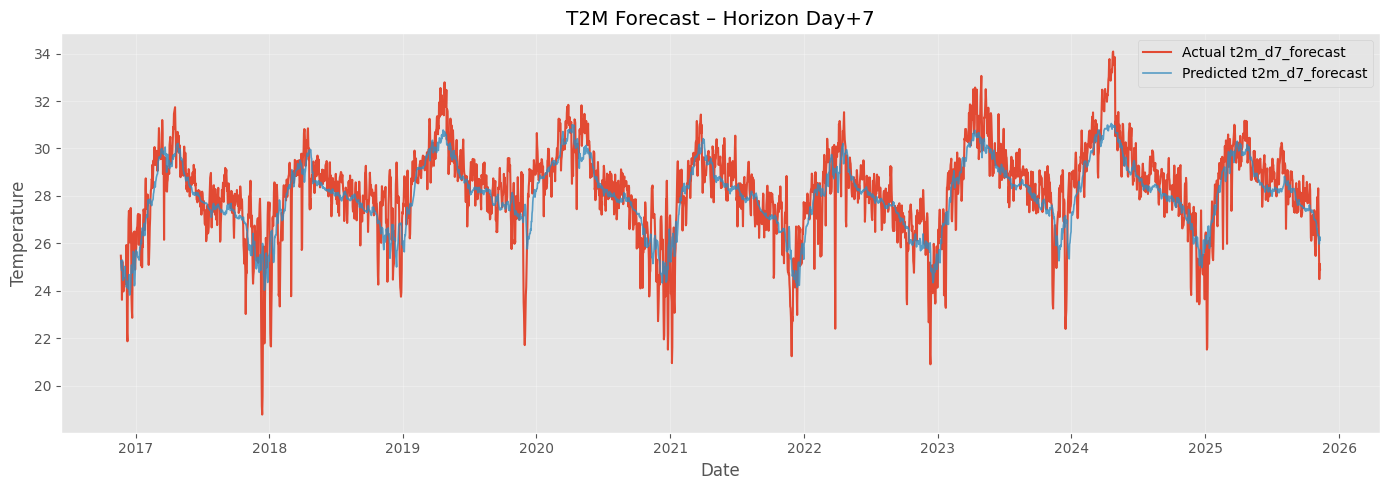

In [64]:
import matplotlib.pyplot as plt

# สร้าง date index สำหรับ test set
dates_test = pd.to_datetime(df["date"].iloc[split_idx:])

# เลือก horizon ที่อยากดู เช่น day+7 = index 6
h = 6   # 0 = day+1, 6 = day+7
target_name = t2m_targets[h]

plt.figure(figsize=(14, 5))
plt.plot(dates_test, Y_test.iloc[:, h], label=f"Actual {target_name}", linewidth=1.5)
plt.plot(dates_test, Y_pred[:, h], label=f"Predicted {target_name}", linewidth=1.2, alpha=0.8)

plt.title(f"T2M Forecast – Horizon Day+{h+1}")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

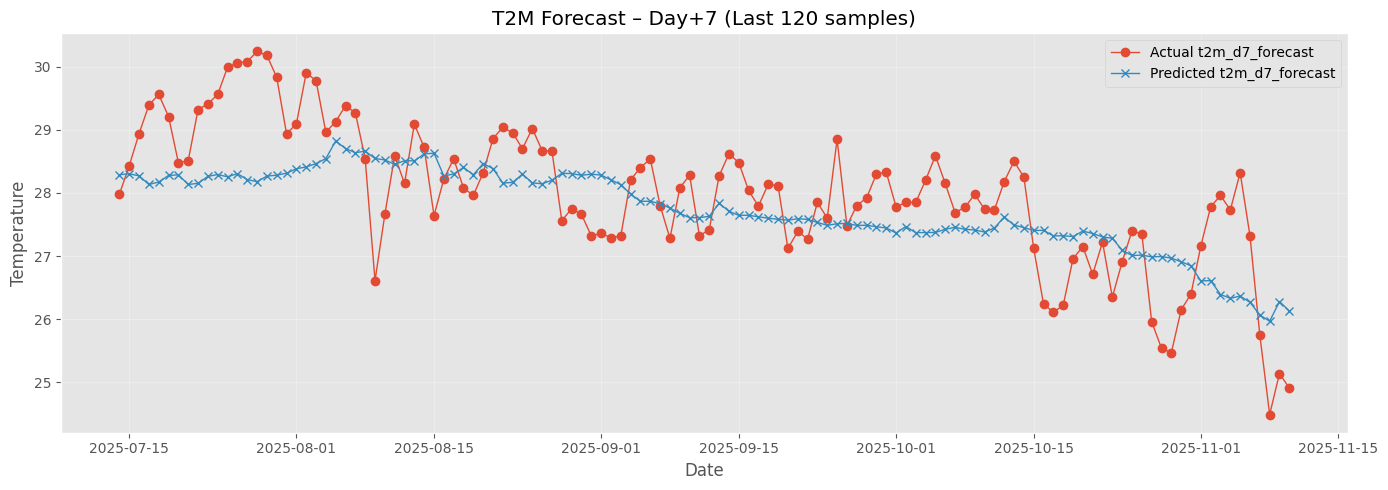

In [65]:
# จำนวนจุดที่อยาก zoom ดู
N = 120  # เช่น 4 เดือนสุดท้าย

dates_zoom = dates_test[-N:]
y_test_zoom = Y_test.iloc[-N:, h]
y_pred_zoom = Y_pred[-N:, h]

plt.figure(figsize=(14, 5))
plt.plot(dates_zoom, y_test_zoom, label=f"Actual {target_name}", marker="o", linewidth=1)
plt.plot(dates_zoom, y_pred_zoom, label=f"Predicted {target_name}", marker="x", linewidth=1)

plt.title(f"T2M Forecast – Day+{h+1} (Last {N} samples)")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

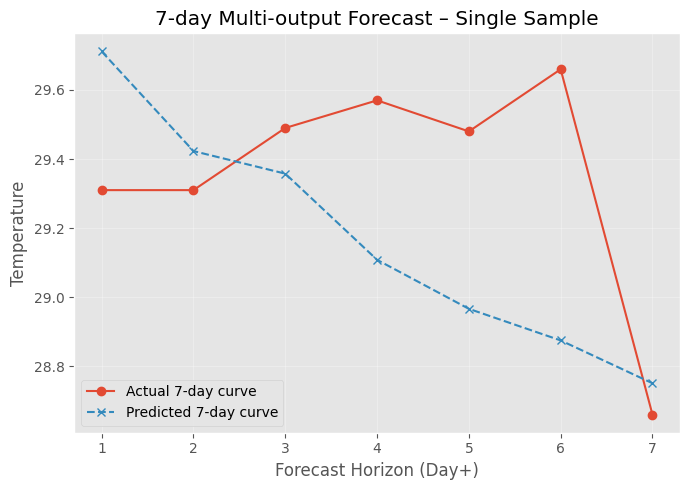

Actual 7-day values: [29.31 29.31 29.49 29.57 29.48 29.66 28.66]
Predicted 7-day values: [29.71150479 29.4230856  29.35766047 29.1081339  28.96622398 28.87472607
 28.75069589]


In [66]:
# เลือก sample index จาก test set เช่น sample ตรงกลาง
k = len(Y_test) // 2   # หรือจะใช้ -1 ดู sample สุดท้ายก็ได้

true_7 = Y_test.iloc[k].values       # shape = (7,)
pred_7 = Y_pred[k]                   # shape = (7,)

days = np.arange(1, H+1)

plt.figure(figsize=(7, 5))
plt.plot(days, true_7, marker="o", label="Actual 7-day curve")
plt.plot(days, pred_7, marker="x", linestyle="--", label="Predicted 7-day curve")

plt.xticks(days)
plt.xlabel("Forecast Horizon (Day+)")
plt.ylabel("Temperature")
plt.title("7-day Multi-output Forecast – Single Sample")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Actual 7-day values:", true_7)
print("Predicted 7-day values:", pred_7)